In [7]:
!pip install timm

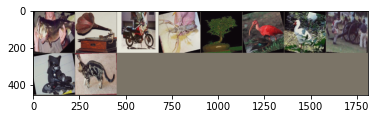

In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import timm


plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '../input/caltech101/Caltech101/Caltech101'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'eval', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])



In [9]:
model_ft = timm.create_model("efficientnet_b1", pretrained=True)
num_ftrs = model_ft.classifier.in_features

half_in_size = round(num_ftrs/2)
layer_width = 2048
Num_class=101

class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x

In [10]:
model_ft.classifier = SpinalNetV1()

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
#             if test_token ==0 and phase == 'test':
#                 continue
#             test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))



        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.3529 Acc: 0.2897
eval Loss: 3.0650 Acc: 0.5488
Training complete in 2m 23s
test Loss: 3.0968 Acc: 0.5422

Epoch 1/24
----------
train Loss: 2.0639 Acc: 0.6243
eval Loss: 2.0639 Acc: 0.8159
Training complete in 4m 24s
test Loss: 2.0731 Acc: 0.8029

Epoch 2/24
----------
train Loss: 0.8375 Acc: 0.8317
eval Loss: 1.4456 Acc: 0.9280
Training complete in 6m 14s
test Loss: 1.4545 Acc: 0.9156

Epoch 3/24
----------
train Loss: 0.4582 Acc: 0.8934
eval Loss: 1.1354 Acc: 0.9451
Training complete in 8m 4s
test Loss: 1.1340 Acc: 0.9298

Epoch 4/24
----------
train Loss: 0.3003 Acc: 0.9263
eval Loss: 0.9841 Acc: 0.9512
Training complete in 9m 54s
test Loss: 0.9988 Acc: 0.9445

Epoch 5/24
----------
train Loss: 0.2202 Acc: 0.9489
eval Loss: 0.8470 Acc: 0.9476
test Loss: 0.8653 Acc: 0.9375

Epoch 6/24
----------
train Loss: 0.1780 Acc: 0.9557
eval Loss: 0.8024 Acc: 0.9573
Training complete in 13m 34s
test Loss: 0.8091 Acc: 0.9522

Epoch 7/24
----------
train Loss: 

In [13]:
!pip install disarray
import disarray
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
nb_classes = 101

valid_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (valid_inputs, valid_classes) in enumerate(dataloaders['eval']):
        valid_inputs = valid_inputs.to(device)
        valid_classes = valid_classes.to(device)
        valid_outputs = model_ft(valid_inputs)
        _, valid_preds = torch.max(valid_outputs, 1)
        for t, p in zip(valid_classes.view(-1), valid_preds.view(-1)):
            valid_confusion_matrix[t.long(), p.long()] += 1

print(valid_confusion_matrix)

tensor([[43.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 43.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 20.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  5.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  6.]])


Text(0.5, 113.09375, 'Predicted label')

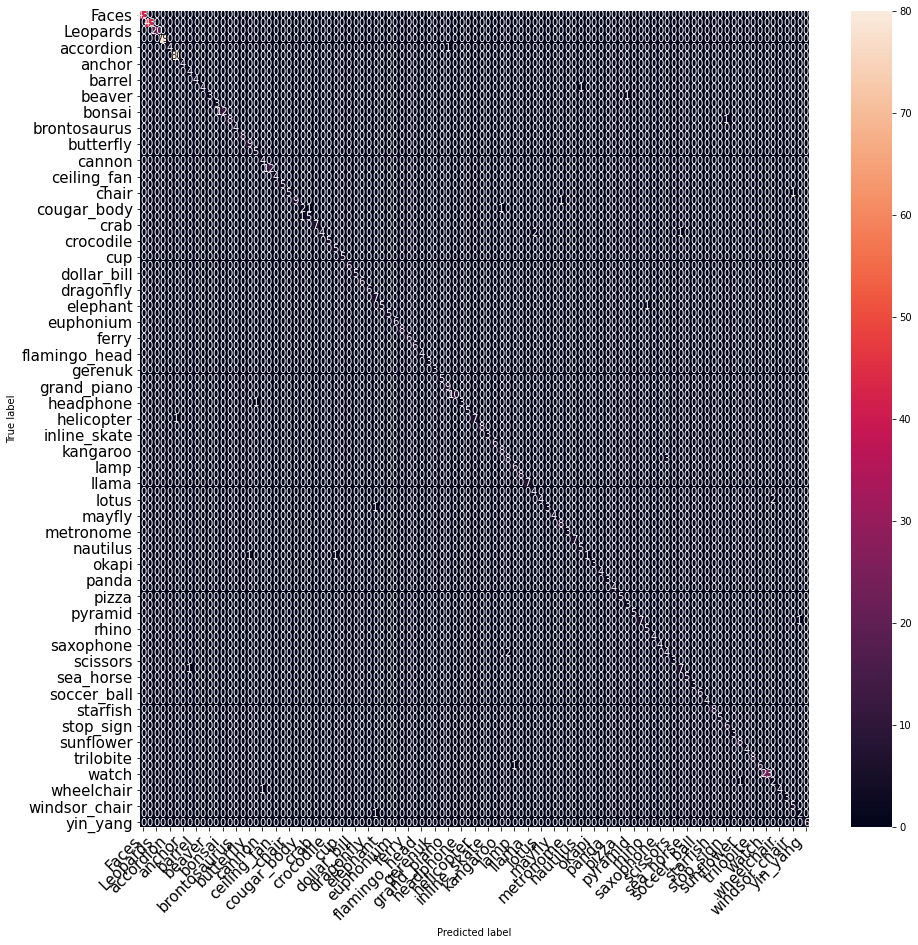

In [15]:
plt.figure(figsize=(15,15))
valid_class_names = list(image_datasets['eval'].classes)
valid_df_cm = pd.DataFrame(valid_confusion_matrix, index=class_names, columns=class_names).astype(int)
valid_heatmap = sns.heatmap(valid_df_cm, annot=True, fmt="d")

valid_heatmap.yaxis.set_ticklabels(valid_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
valid_heatmap.xaxis.set_ticklabels(valid_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [16]:
valid_recall = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 1)
valid_precision = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 0)
print("Recall")
print(valid_recall.mean())

print("\nPresisi")
print(valid_precision.mean())

Recall
0.9427696341062678

Presisi
0.9509189411004594


In [17]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print('accuracy: {:3f}'.format(accuracy(valid_confusion_matrix)))
print('precision: {:3f}'.format(valid_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(valid_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(valid_df_cm.da.f1.mean()))

accuracy: 0.962195
precision: 0.950919
recall: 0.942770
f1: 0.941293


In [18]:
#TEST
nb_classes = 101

test_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (test_inputs, test_classes) in enumerate(dataloaders['test']):
        test_inputs = test_inputs.to(device)
        test_classes = test_classes.to(device)
        test_outputs = model_ft(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        for t, p in zip(test_classes.view(-1), test_preds.view(-1)):
            test_confusion_matrix[t.long(), p.long()] += 1

print(test_confusion_matrix)

tensor([[87.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1., 86.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 40.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 11.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  6.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 12.]])


     |████████████████████████████████| 243 kB 1.3 MB/s eta 0:00:01


Text(0.5, 68.09375, 'Predicted label')

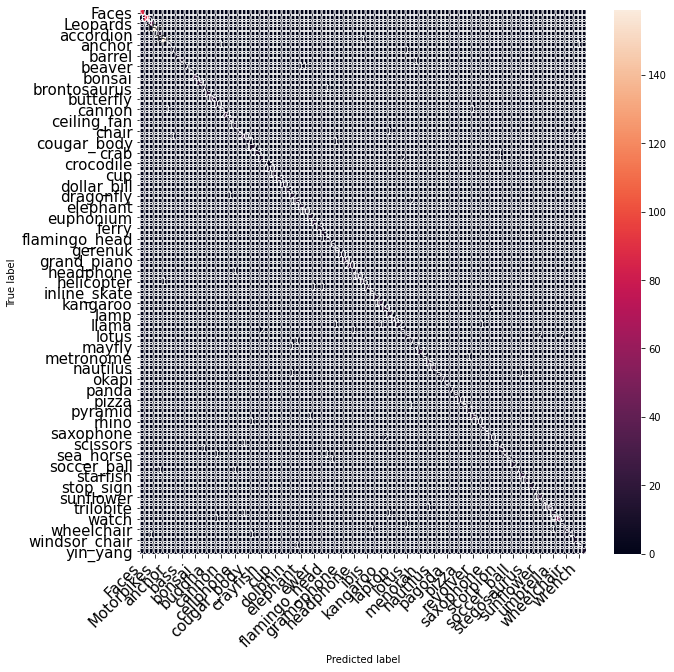

In [19]:
!pip install openpyxl
plt.figure(figsize=(10,10))

class_names = list(image_datasets['test'].classes)
test_df_cm = pd.DataFrame(test_confusion_matrix, index=class_names, columns=class_names).astype(int)
test_heatmap = sns.heatmap(test_df_cm, annot=True, fmt="d")
test_df_cm.to_excel('CVS1_Vision Transformer_SpinalNet_test_confusion_matrix.xlsx')


test_heatmap.yaxis.set_ticklabels(test_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
test_heatmap.xaxis.set_ticklabels(test_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
test_recall = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 1)
test_precision = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 0)
print("Recall")
print(test_recall.mean())

print("\nPresisi")
print(test_precision.mean())

Recall
0.9319072333847198

Presisi
0.9392738149900677


In [21]:
print('accuracy: {:3f}'.format(accuracy(test_confusion_matrix)))
print('precision: {:3f}'.format(test_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(test_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(test_df_cm.da.f1.mean()))

accuracy: 0.956932
precision: 0.939274
recall: 0.931907
f1: 0.932264
